# Optimize Indicator

## 181025 Code Refactoring

속도 개선 / 가독성 고려하여 refactoring

*Goal : 함수 마다 10줄 이내로 작업하기*

In [37]:
from antQuant.utils import indicators
from antQuant.utils.datamanager import DataManager
import json
import pandas as pd
import datetime
# import pandas_datareader as pdr
from collections import deque
import numpy as np
import time
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
dm = DataManager()
df = dm.get_adj_daily_ohlcv('005930')

In [20]:
df.iloc[df.index.get_loc('1990-01-06')]

open      8.587090e+00
high      8.625430e+00
low       8.529590e+00
close     8.529590e+00
volume    1.376280e+08
Name: 1990-01-06 00:00:00, dtype: float64

## Class : tech_strategy

#### tech_strategy : 기술지표/전략을 총괄하는 class

In [21]:
class tech_strategy:
    
    def __init__(self, code, period, strategy):
        self.code = code
        self.period = period
        self.strategy_list = strategy
        self.datamanager = DataManager()
        self.result = dict()
        adj_date = datetime.datetime.strptime(self.period[0], '%Y-%m-%d') - datetime.timedelta(days=100)
        end_date = self.period[1]
        self.stock_df = self.datamanager.get_adj_daily_ohlcv(self.code, start=adj_date, end=end_date)
        
    def load_strategy(self): 
        # load_strategy : strategy.json에 저장된 전략을 읽어오는 메서드
        self.strategy_data = {}
        with open('strategy2.json', mode='r', encoding='utf-8') as f:
            data = json.load(f)
        for da in data:
            self.strategy_data[da['name']]=da
        
    def load_indicator(self): 
        # load_indicator : ChartStrategy.json에 저장된 기술지표 정보를 읽어오는 메서드
        self.indicator_data = {}
        with open('ChartStrategy.json', mode='r', encoding='utf-8') as f:
            data = json.load(f)
        for da in data:
            self.indicator_data[da['indicators']]=da
        
    def run_strategy(self):
        # run_strategy : 입력 받은 기간에 대해 전략을 run 하는 메서드
        st = time.time()
        self.load_strategy()
        et = time.time()
        print("function load_strategy took %f seconds"%(et-st))
        
        for i in self.strategy_list:
            self.strategy = i
            self.buy_signal = self.strategy_data[i]['Buy_signal']
            self.sell_signal = self.strategy_data[i]['Sell_signal']
            self.result[i] = self.get_perform_result()
            
        return self.result
    
    def _get_function_type(self, function):
        # _get_function_type : 지표가 상수함수인지 데이터를 통해 계산 해야 되는 함수인지를 판별하여 타입을 반환하는 메서드
        try:
            return len(function)
        except:
            return 'constant'    
    
    def get_indicator_data(self, function):
        # get_indicator_data : 해당 종목과 기간에 대한 지표 계산값을 반환하는 메서드
        function_type = self._get_function_type(function)
        
        if isinstance(function_type, str):
            # print('상수함수')
            df = pd.Series(function, index = self.stock_df.index)
            return df
        elif function_type == 2: # return 이 하나인 함수 eg. ["SMA", [5]] = [function, parameter]
            indicator = function[0]
            param = function[1]
        elif function_type == 3: # return 이 여러개인 함수 eg. ["MACD",0,[12,26,9]] = [function, order, parameter]
            indicator = function[0]
            function_order = function[1]
            param = function[2]        
        
        self.load_indicator()
        input_data = self.indicator_data[indicator]['input_data']
        input_list = [self.stock_df[i] for i in input_data]
        indicator_function = getattr(indicators, indicator)

        if function_type == 2:
            return(indicator_function(*input_list, *param))
        else:
            return(indicator_function(*input_list, *param)[function_order]) 

    def load_data(self):
        # load_data : 지표 simulation 에 필요한 데이터를 준비하는 메서드
        start_date = self.stock_df.index[0]
        end_date = self.stock_df.index[-1]
        
        self.criteria = self.buy_signal[0]
        function1 = self.buy_signal[1]
        function2 = self.buy_signal[2]
        function3 = self.sell_signal[2] # 비교 대상이 다른 경우를 체크하기 위함, eg. RSI 와 같은 지표
        
        tr_date = []
        
        if self.criteria == 'Crossup':
            self.criteria = 1
            data1 = self.get_indicator_data(function1)
            data2 = self.get_indicator_data(function2)
            
            if function2 == function3 :
                self.use_third_function = False
                data3 = data2
            else:
                self.use_third_function = True
                data3 = self.get_indicator_data(function3) # 비교 대상이 다르면 그거에 대한 데이터 가져오기
                
        elif self.criteria == 'Crossdown':
            self.criteria = -1
            data1 = self.get_indicator_data(function2)
            data2 = self.get_indicator_data(function1)
            
            if function2 == function3 : 
                data3 = data1
            else:
                data3 = self.get_indicator_data(function3) # 비교 대상이 다르면 그거에 대한 데이터 가져오기
                
        return data1, data2, data3
        
    def get_perform_result(self):
        # get_perform_result : 실질적인 전략 시뮬레이션이 일어나는 메서드
        st = time.time()
        data1,data2,data3 = self.load_data()
        et = time.time()
        print("function load_data took %f seconds"%(et-st))
                
        st = time.time()
        start_date = self.period[0]
        end_date = self.period[1]
        before_1day = self.stock_df.loc[:start_date].index[-2] # 이전 개장일 (start_date 가 개장일이 아닐경우 고려하여 이렇게 작성)
        

        slice_data1 = data1[start_date:]
        slice_data2 = data2[start_date:]
        
        if self.use_third_function :
            slice_data3 = data3[start_date:] # 비교 대상이 다르면 그거에 대한 데이터 가져오기
            
        else:
            slice_data3 = slice_data2
                   
        
        history_data = pd.DataFrame(columns = ['trading','price','win_count','lose_count','winning_rate', 'net_profit'])
        win_count = 0
        lose_count = 0
        net_profit = 0
        total_revenue = 0
        total_loss = 0
        short_dict = dict()
        short_dict['price'] = 0
        short_dict['shares'] = 0
        long_dict = dict()
        long_dict['price'] = 0
        long_dict['shares'] = 0
        
        for i in range(1,len(slice_data1)):
            
            con1 = slice_data1.iloc[i-1] < slice_data2.iloc[i-1]
            con2 = slice_data1.iloc[i] > slice_data2.iloc[i] # 금일에 대한 데이터 비교
            
            if self.criteria == 1: # sell shoud be cross down
                con3 = slice_data1.iloc[i-1] > slice_data3.iloc[i-1] # 어제 비교
                con4 = slice_data1.iloc[i] < slice_data3.iloc[i] # 금일에 대한 데이터 비교
                           
            elif self.criteria == -1: # sell shoud be cross up
                con3 = slice_data2.iloc[i-1] < slice_data3.iloc[i-1] # 어제 비교
                con4 = slice_data2.iloc[i] > slice_data3.iloc[i] # 금일에 대한 데이터 비교
                        
            if(con1*con2 or con3*con4): # if transaction occur
                d = dict()
                d['idx'] = slice_data1.index[i]
                current_price = self.stock_df['close'].loc[d['idx']]
                d['price'] = current_price
                
                if(con1*con2): # buy signal
                    d['trading'] = 'Buy'
                    long_dict['shares'] += 1
                    # 새로운 평단가 계산
                    long_dict['price'] = (long_dict['price'] * (long_dict['shares'] - 1) + current_price) / long_dict['shares']

                if(con3*con4): # sell signal
                    d['trading'] = 'Sell'
                    short_dict['shares'] += 1
                    # 새로운 평단가 계산
                    short_dict['price'] = (short_dict['price'] * (short_dict['shares'] - 1) + current_price) / short_dict['shares']

                if short_dict['shares'] != 0 and long_dict['shares'] != 0 :
                    buy_price = long_dict['price']
                    sell_price = short_dict['price']

                    if buy_price < sell_price :
                        win_count += 1
                        total_revenue += sell_price - buy_price
                    elif buy_price > sell_price :
                        lose_count += 1
                        total_loss += buy_price - sell_price
                    net_profit += sell_price - buy_price

                    long_dict['shares'] -= 1
                    short_dict['shares'] -= 1

                d['win_count'] = win_count
                d['lose_count'] = lose_count
                d['net_profit'] = net_profit
                if(win_count + lose_count > 0 ):
                    d['winning_rate'] = win_count / (win_count + lose_count)
                else:
                    d['winning_rate'] = np.NaN
                # update data frame
                history_data.loc[d['idx']] = [d['trading'],d['price'],d['win_count'],d['lose_count'],d['winning_rate'],d['net_profit']]
        
        # total_summary에 대한 정보를 생성
        total_summary = dict()
        total_summary['Net_Profit'] = net_profit
        total_summary['Transaction_Count'] = len(history_data)
        total_summary['Total_Revenue'] = total_revenue
        total_summary['Total_Loss'] = - total_loss
        total_summary['Profit_Factor'] = total_revenue / total_loss
        total_summary['Win_Count'] = win_count
        total_summary['Lose_Count'] = lose_count
        total_summary['max_revenue'] = history_data['net_profit'].max()
        total_summary['max_loss'] = history_data['net_profit'].min()
        
        et = time.time()
        # 시간 측정 메소드
        print("function get_perform_result took %f seconds"%(et-st))
        return history_data, total_summary

In [22]:
def optimize_indicator(code, period, strategy_list):
    # 특정 종목, 기간 및 전략에 대한 지표 최적화를 수행
    a = tech_strategy(code, period, strategy_list)
    return a.run_strategy()

### 데이터를 통한 테스팅

삼성전자 종목에 대해 2016년 1월 10일 부터 2018년 3월 10일 까지 '이동평균선 크로스', 'Custom Binary Wave', 'RSI 기준선' 전략을 적용하여 결과를 확인

### Total Result

In [25]:
selected_list = ['이동평균선 크로스','Custom Binary Wave','RSI 기준선']
perform_result = optimize_indicator('005930', ('2016-01-10','2018-03-10'), selected_list)

function load_strategy took 0.000000 seconds
function load_data took 0.001996 seconds
function get_perform_result took 0.233374 seconds
function load_data took 0.186535 seconds
function get_perform_result took 0.549497 seconds
function load_data took 0.001000 seconds
function get_perform_result took 0.143661 seconds


### 특정 전략에 대한 성과 확인 가능

In [30]:
perform_result['이동평균선 크로스'][0] # RSI 기준선 전략에 대한 상세 정보

,trading,price,win_count,lose_count,winning_rate,net_profit
2016-02-02,Buy,462.4,0,0,NaN,0
2016-02-12,Sell,452.0,0,1,0.000000,-10.4
2016-02-17,Buy,474.0,0,1,0.000000,-10.4
2016-04-08,Sell,498.4,1,1,0.500000,14
2016-04-18,Buy,519.6,1,1,0.500000,14
2016-04-28,Sell,506.0,1,2,0.333333,0.4
2016-05-11,Buy,516.8,1,2,0.333333,0.4
2016-05-16,Sell,499.2,1,3,0.250000,-17.2
2016-05-25,Buy,518.0,1,3,0.250000,-17.2
2016-06-30,Sell,570.0,2,3,0.400000,34.8


In [26]:
perform_result['Custom Binary Wave'][0] # Custom Binary Wave 전략에 대한 상세 정보

,trading,price,win_count,lose_count,winning_rate,net_profit
2016-01-26,Sell,454.8,0,0,NaN,0
2016-01-27,Buy,470.0,0,1,0.000000,-15.2
2016-01-28,Sell,458.0,0,1,0.000000,-15.2
2016-01-29,Buy,460.0,0,2,0.000000,-17.2
2016-02-05,Buy,465.6,0,2,0.000000,-17.2
2016-02-11,Sell,452.0,0,3,0.000000,-30.8
2016-02-16,Buy,467.2,0,3,0.000000,-30.8
2016-02-25,Buy,471.6,0,3,0.000000,-30.8
2016-02-29,Buy,471.2,0,3,0.000000,-30.8
2016-03-10,Buy,490.0,0,3,0.000000,-30.8


### 특정 전략에 대한 성과 요약 확인

In [31]:
perform_result['RSI 기준선'][1] # 요약 정보

{'Net_Profit': -287.3333333333335,
 'Transaction_Count': 16,
 'Total_Revenue': 0,
 'Total_Loss': -287.3333333333335,
 'Profit_Factor': 0.0,
 'Win_Count': 0,
 'Lose_Count': 2,
 'max_revenue': 0,
 'max_loss': -287.3333333333335}

In [27]:
perform_result['Custom Binary Wave'][1] # 요약 정보

{'Net_Profit': 185964.43420740965,
 'Transaction_Count': 115,
 'Total_Revenue': 186000.40042963185,
 'Total_Loss': -35.96622222222226,
 'Profit_Factor': 5171.530089549098,
 'Win_Count': 43,
 'Lose_Count': 4,
 'max_revenue': 185964.43420740965,
 'max_loss': -30.80000000000001}

### 특정 전략에 대한 손익 변화 확인

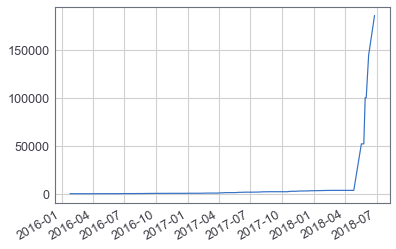

In [39]:
perform_result['Custom Binary Wave'][0]['net_profit'].plot() # net_profit(손익) 상세 정보

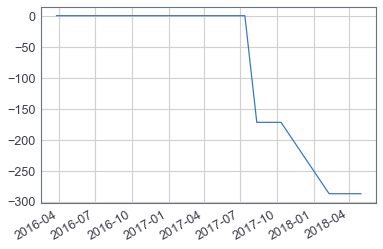

In [41]:
perform_result['RSI 기준선'][0]['net_profit'].plot() # net_profit(손익) 상세 정보